In [3]:
import os
project_root = os.path.abspath("..")

In [6]:

paths = {
    "test_other": "../data/test/x/other",
    "test_guitar": "../data/test/x/guitar",
    "train_other": "../data/train/x/other",
    "train_guitar": "../data/train/x/guitar"
}

for label, path in paths.items():
    if os.path.exists(path):
        num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
        print(f"{label}: {num_files} files")
    else:
        print(f"{label}: ❌ directory does not exist")

test_other: 20 files
test_guitar: 20 files
train_other: 610 files
train_guitar: 700 files


In [7]:
import os
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import pandas as pd

def format_time(seconds):
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    return f"{h}h {m}m {s}s"

def collect_audio_stats(folder_paths_dict):
    lengths = []
    channels = []
    labels = []
    channel_summary = defaultdict(list)

    for label, path in folder_paths_dict.items():
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
            for file_name in files:
                file_path = os.path.join(path, file_name)
                try:
                    data, sr = sf.read(file_path)
                    duration = len(data) / sr
                    num_channels = data.shape[1] if data.ndim > 1 else 1

                    lengths.append(duration)
                    channels.append(num_channels)
                    labels.append(label)
                    channel_summary[label].append(num_channels)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
        else:
            print(f"{label}: ❌ directory does not exist")

    return np.array(lengths), np.array(channels), np.array(labels), channel_summary

def plot_total_lengths(labels, lengths):
    unique_labels = np.unique(labels)
    total_lengths = [lengths[labels == ul].sum() for ul in unique_labels]

    plt.figure(figsize=(10, 5))
    bars = plt.bar(unique_labels, total_lengths, color=plt.cm.tab10.colors[:len(unique_labels)])
    plt.ylabel("Total Audio Length (seconds)")
    plt.title("Total Audio Length per Folder")
    plt.grid(axis='y')

    for bar, total_sec in zip(bars, total_lengths):
        time_str = format_time(total_sec)
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, time_str,
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_length_distribution(lengths_by_label, title="File Length Distribution"):
    plt.figure(figsize=(10, 5))
    for label, lengths in lengths_by_label.items():
        plt.hist(lengths, bins=30, alpha=0.6, label=label, edgecolor='black')
    plt.xlabel("File Length (seconds)")
    plt.ylabel("Number of Files")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def display_channel_count_table(channel_summary):
    channel_table = {}

    for label, ch_list in channel_summary.items():
        count = Counter(ch_list)
        channel_table[label] = dict(count)

    # Convert to DataFrame
    channel_df = pd.DataFrame.from_dict(channel_table, orient='index').fillna(0).astype(int)

    # Sort for consistency
    channel_df = channel_df.sort_index(axis=0).sort_index(axis=1)

    display(channel_df)



In [34]:
# --- Collect stats for base folders ---
lengths, channels, labels, channel_summary = collect_audio_stats(paths)

# Display number of channels across dataset
display_channel_count_table(channel_summary)

1    2
test_guitar     0   20
test_other      0   20
train_guitar  699    1
train_other   468  142

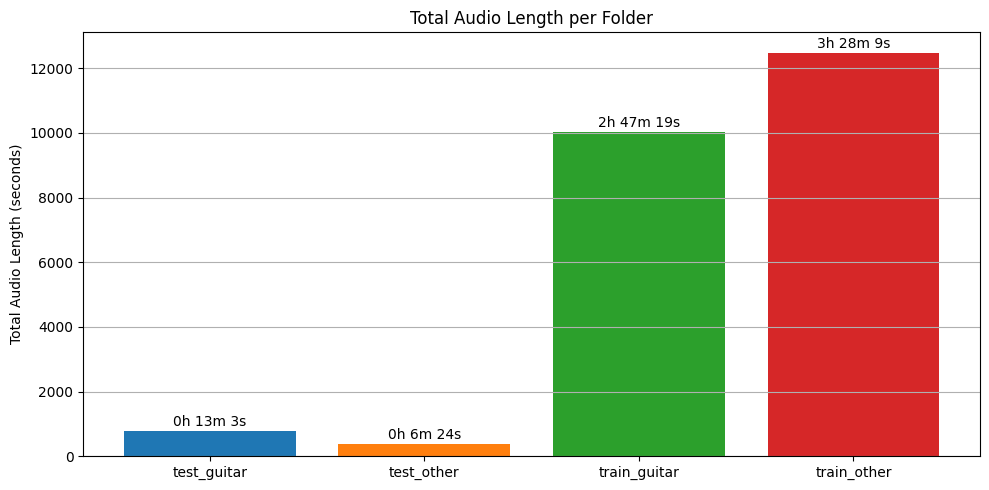

In [10]:
# Plot total durations
plot_total_lengths(labels, lengths)

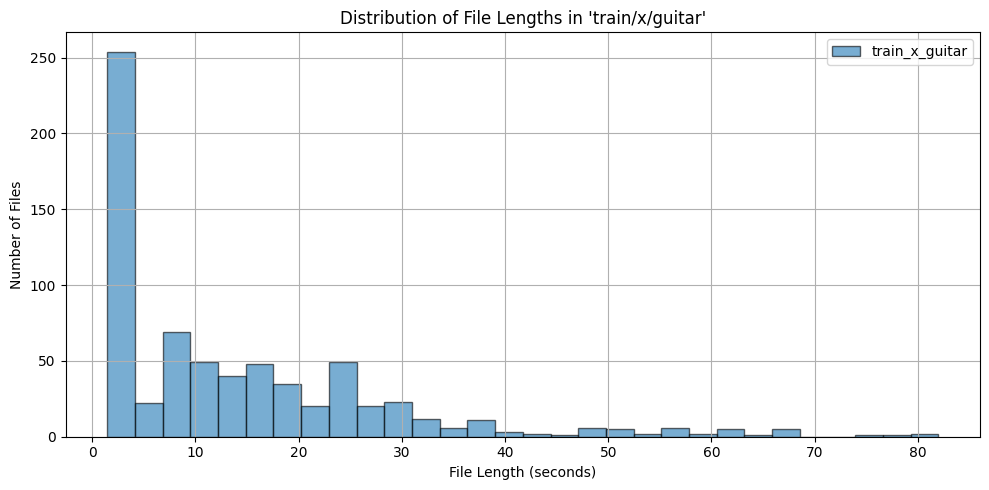

In [11]:
# Plot file length distribution for original train_guitar
train_guitar_lengths = lengths[labels == "train_guitar"]
plot_length_distribution({"train_x_guitar": train_guitar_lengths},
                         title="Distribution of File Lengths in 'train/x/guitar'")

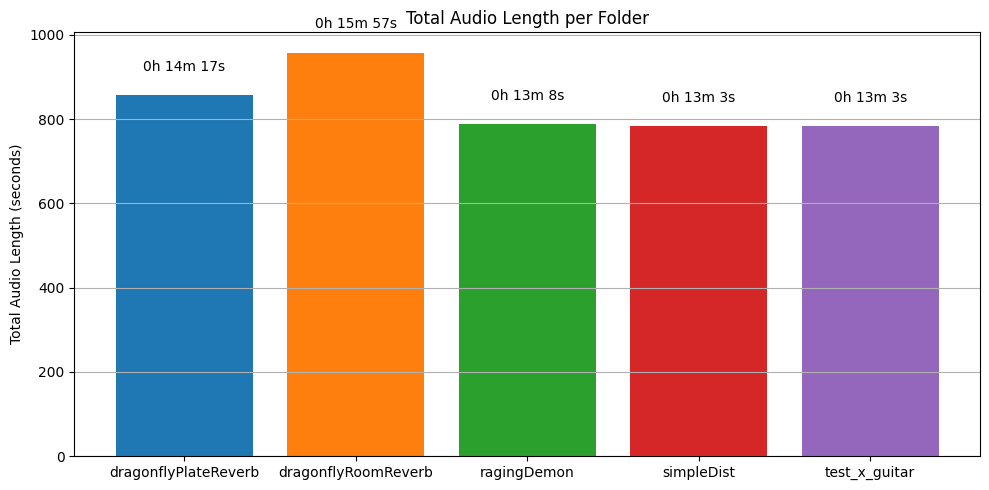

In [13]:
# --- Compare total lengths of test/x/guitar vs test/y/guitar/{effects} ---

effect_base_dir = "../data/test/y/guitar"
effect_subdirs = [d for d in os.listdir(effect_base_dir)
                  if os.path.isdir(os.path.join(effect_base_dir, d))]

# Prepare path dict for all effects
effect_paths = {f"{effect}": os.path.join(effect_base_dir, effect)
                for effect in effect_subdirs}

# Add original test_x_guitar for comparison
effect_paths["test_x_guitar"] = "../data/test/x/guitar"

# Collect stats
effect_lengths, _, effect_labels, _ = collect_audio_stats(effect_paths)

# Plot total durations
plot_total_lengths(effect_labels, effect_lengths)


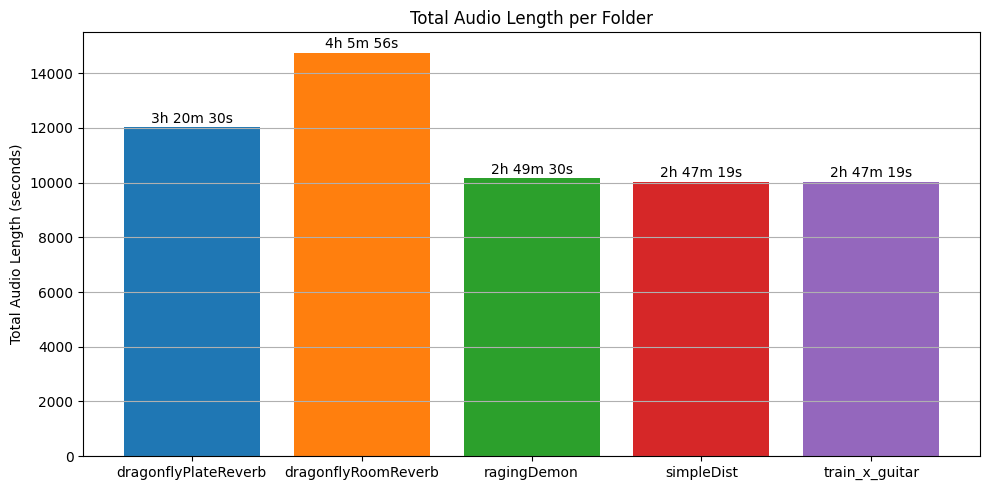

In [15]:
# --- Compare total lengths of test/x/guitar vs test/y/guitar/{effects} ---

effect_base_dir = "../data/train/y/guitar"
effect_subdirs = [d for d in os.listdir(effect_base_dir)
                  if os.path.isdir(os.path.join(effect_base_dir, d))]

# Prepare path dict for all effects
effect_paths = {f"{effect}": os.path.join(effect_base_dir, effect)
                for effect in effect_subdirs}

# Add original test_x_guitar for comparison
effect_paths["train_x_guitar"] = "../data/train/x/guitar"

# Collect stats
effect_lengths, _, effect_labels, _ = collect_audio_stats(effect_paths)

# Plot total durations
plot_total_lengths(effect_labels, effect_lengths)

In [16]:
import torch

print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using device:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA Available: True
Number of GPUs: 1
Using device: NVIDIA GeForce GTX 1050 Ti


In [17]:
response_times = {
    "simpleDist": {"seconds": 0.000, "samples": 0},
    "ragingDemon": {"seconds": 0.188, "samples": 8271},
    "dragonflyPlateReverb": {"seconds": 2.844, "samples": 125413},
    "dragonflyRoomReverb": {"seconds": 6.738, "samples": 297165},
}

df = pd.DataFrame.from_dict(response_times, orient='index')

display(df)

seconds  samples
simpleDist              0.000        0
ragingDemon             0.188     8271
dragonflyPlateReverb    2.844   125413
dragonflyRoomReverb     6.738   297165

In [35]:
lengths, channels, labels, channel_summary = collect_audio_stats({
    "test_y_simpleDist": "../data/test/y/guitar/simpleDist",
    "train_y_simpleDist": "../data/train/y/guitar/simpleDist",
    "test_y_ragingDemon": "../data/test/y/guitar/ragingDemon",
    "train_y_ragingDemon": "../data/train/y/guitar/ragingDemon"
})
display_channel_count_table(channel_summary)


2
test_y_ragingDemon    20
test_y_simpleDist     20
train_y_ragingDemon  700
train_y_simpleDist   700

In [7]:
import os
import math
import argparse
import numpy as np
from scipy.io import wavfile
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import IPython.display as ipd


# Normalize funkcija
def normalize(data):
    data_max = np.max(data)
    data_min = np.min(data)
    data_norm = max(abs(data_max), abs(data_min))
    return data / data_norm

class GuitarDataset(Dataset):
    def __init__(self, X_all, y_all, input_size):
        # Kreiraj ulazne sekvence i target vektore
        # X_all, y_all shape = (N, 1)
        self.input_size = input_size
        
        self.X_all = torch.from_numpy(X_all).float().squeeze(-1)  # shape (N,)
        self.y_all = torch.from_numpy(y_all).float().squeeze(-1)  # shape (N,)
        
        self.length = len(self.X_all) - input_size + 1

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        X_seq = self.X_all[idx : idx + self.input_size].unsqueeze(-1)  # shape (input_size, 1)
        y_val = self.y_all[idx + self.input_size - 1]  # scalar
        return X_seq, y_val
    

in_file = "../data/test/x/guitar/acoustic-guitar-logo-13084.wav"
out_file = "../data/test/y/guitar/simpleDist/acoustic-guitar-logo-13084.wav"
input_size = 100  # Velicina ulazne sekvence

in_rate, in_data = wavfile.read(in_file)
out_rate, out_data = wavfile.read(out_file)
assert in_rate == 44100 and out_rate == 44100, "Sampling rate must be 44100 Hz"

X_all = normalize(in_data.astype(np.float32)).reshape(-1, 1)
y_all = normalize(out_data.astype(np.float32)).reshape(-1, 1)

# Dataset i DataLoader
dataset = GuitarDataset(X_all, y_all, input_size)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get the first batch from the DataLoader
for X_batch, y_batch in dataloader:
    first_input_seq = X_batch[0].squeeze().numpy()   # Shape: (input_size,)
    target_value = y_batch[0].item()                 # Single float

    print("Input shape:", first_input_seq.shape)
    print("Target value (last sample of y):", target_value)

    # Play the input sequence as audio
    ipd.display(ipd.Audio(first_input_seq, rate=44100))

    break  # We only want the first batch

Input shape: (100,)
Target value (last sample of y): 0.990814208984375


In [ ]:
import os
import math
import argparse
import numpy as np
from scipy.io import wavfile
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import IPython.display as ipd
from IPython.display import display, Audio


# Normalize funkcija
def normalize(data):
    data_max = np.max(data)
    data_min = np.min(data)
    data_norm = max(abs(data_max), abs(data_min))
    return data / data_norm

class GuitarDataset(Dataset):
    

    def __init__(self, input_dir, target_dir, input_size, max_samples=50000):
        self.input_size = input_size
        self.pairs = []
        self.cum_sum = []

        input_files = sorted(os.listdir(input_dir))

        total_length = 0
        for fname in input_files:
            # if file is not audio, ignore
            if not fname.lower().endswith('.wav'):
              continue

            # if there is no matching output file, ignore
            in_path = os.path.join(input_dir, fname)
            out_path = os.path.join(target_dir, fname)
            if not os.path.exists(out_path):
                continue

            # if samplerates don't match, ignore
            in_rate, in_data = wavfile.read(in_path)
            out_rate, out_data = wavfile.read(out_path)

            if in_rate != out_rate: #in_rate != 44100 or out_rate != 44100:
                continue

            max_len = max(len(in_data), len(out_data)) #max lenth in number of samples
            # in data cant be longer than out data

            total_length += max_len

            self.cum_sum.append(total_length)
            self.pairs.append((in_path, out_path))



    def __len__(self):
        return self.cum_sum[-1]

    def __getitem__(self, idx):
        # Find which file the idx corresponds to
        file_index_start = bisect_left(self.cum_sum, idx)
        file_index_end = bisect_left(self.cum_sum, idx + self.input_size)

        self.file_indexes_ready = []
        self.samples_input_ready = []
        self.samples_output_ready = []

        for file_idx in range(file_index_start, file_index_end):
          in_path, out_path = self.pairs[file_idx]
          in_rate, in_data = wavfile.read(in_path)
          out_rate, out_data = wavfile.read(out_path)

          in_data = normalize(in_data.astype(np.float32)).reshape(-1)
          out_data = normalize(out_data.astype(np.float32)).reshape(-1)

          max_len = max(len(in_data), len(out_data))
          print(len(in_data), len(out_data))
          if len(in_data) < max_len:
              in_data = np.pad(in_data, (0, max_len - len(in_data)))
          if len(out_data) < max_len:
              out_data = np.pad(out_data, (0, max_len - len(out_data)))

          print(len(in_data), len(out_data))
          # append all the loaded files before finding index
          self.file_indexes_ready.append(file_idx)
          self.samples_input_ready.extend(in_data.tolist())
          self.samples_output_ready.extend(out_data.tolist())


        local_idx = idx - self.cum_sum[file_index_start]

        x_window = self.samples_input_ready[local_idx : local_idx + self.input_size]
        y_value = self.samples_output_ready[local_idx + self.input_size - 1]

        x_tensor = torch.tensor(x_window).unsqueeze(-1)  # (input_size, 1)
        y_tensor = torch.tensor(y_value)

        return x_tensor, y_tensor


# Pre-emphasis filter funkcija
def pre_emphasis_filter(x, coeff=0.95):
    # x je tensor shape (batch_size, seq_len)
    # primeni y[t] = x[t] - coeff * x[t-1]
    y = torch.zeros_like(x)
    y[:, 0] = x[:, 0]
    y[:, 1:] = x[:, 1:] - coeff * x[:, :-1]
    return y

# Custom loss: Error to signal ratio sa pre-emphasis filterom
def error_to_signal(y_true, y_pred):
    y_true_f = pre_emphasis_filter(y_true)
    y_pred_f = pre_emphasis_filter(y_pred)
    numerator = torch.sum((y_true_f - y_pred_f)**2, dim=1)
    denominator = torch.sum(y_true_f**2, dim=1) + 1e-10
    loss = numerator / denominator
    return torch.mean(loss)

def save_wav(name, data):
    wavfile.write(name, 44100, data.flatten().astype(np.float32))

# Model klasa
class GuitarAmpModel(nn.Module):
    def compute_same_padding(self, kernel_size, stride):
        pad = max((stride - 1) + kernel_size - stride, 0)
        pad_left = pad // 2
        pad_right = pad - pad_left
        return pad_left, pad_right

    def __init__(self, conv1d_filters, conv1d_stride, hidden_units, input_size):
        super().__init__()
        pad1_left, pad1_right = self.compute_same_padding(12, conv1d_stride)
        self.pad1 = nn.ConstantPad1d((pad1_left, pad1_right), 0)
        self.conv1 = nn.Conv1d(1, conv1d_filters, 12, stride=conv1d_stride)

        pad2_left, pad2_right = self.compute_same_padding(12, conv1d_stride)
        self.pad2 = nn.ConstantPad1d((pad2_left, pad2_right), 0)
        self.conv2 = nn.Conv1d(conv1d_filters, conv1d_filters, 12, stride=conv1d_stride)

        self.lstm = nn.LSTM(input_size=conv1d_filters, hidden_size=hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, 1)
        x = x.permute(0, 2, 1)  # (batch, channels=1, seq_len)
        x = self.pad1(x)
        x = self.conv1(x)
        x = self.pad2(x)
        x = self.conv2(x)
        x = x.permute(0, 2, 1)  # (batch, seq_len, features)
        # LSTM expects (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # Uzmi poslednji vremenski korak
        last_out = lstm_out[:, -1, :]  # (batch, hidden_units)
        out = self.fc(last_out)         # (batch, 1)
        return out.squeeze(1)           # (batch,)




def main():
    name = "model"
    os.makedirs('models/' + name, exist_ok=True)

    epochs = 10

    learning_rate = 0.001
    conv1d_stride = 12
    conv1d_filters = 8
    hidden_units = 8

    input_dir = "E:/source/dipl/data/train/x/guitar/"
    target_dir = "E:/source/dipl/data/train/y/guitar/simpleDist/"
    input_size = 2

    dataset = GuitarDataset(input_dir, target_dir, input_size)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    
    # Napravi model i optimizer
    model = GuitarAmpModel(conv1d_filters, conv1d_stride, hidden_units, input_size)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Treniranje
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = error_to_signal(batch_y.unsqueeze(1), outputs.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        optimizer.learn_rate = learning_rate * (0.1 ** (epoch // 2))  # Learning rate decay every 3 epochs
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.6f}")

    # Save model i input_size info
    model_path = f'models/{name}/{name}.pt'
    torch.save({
        'model_state_dict': model.state_dict(),
        'input_size': input_size,
        'conv1d_filters': conv1d_filters,
        'conv1d_stride': conv1d_stride,
        'hidden_units': hidden_units
    }, model_path)


    model.eval()
    with torch.no_grad():
        input_dir = "E:/source/dipl/data/test/x/guitar/"
        target_dir = "E:/source/dipl/data/test/y/guitar/simpleDist/"

        # Pick one pair of full input and target audio
        input_files = sorted(os.listdir(input_dir))
        fname = input_files[0]  # Evaluate on the first file
        in_path = os.path.join(input_dir, fname)
        out_path = os.path.join(target_dir, fname)

        # Read and normalize audio
        in_rate, in_data = wavfile.read(in_path)
        out_rate, out_data = wavfile.read(out_path)
        assert in_rate == 44100 and out_rate == 44100

        in_data = normalize(in_data.astype(np.float32)).reshape(-1)
        out_data = normalize(out_data.astype(np.float32)).reshape(-1)
        min_len = min(len(in_data), len(out_data))

        in_data = in_data[:min_len]
        out_data = out_data[:min_len]

        # Prepare model inputs with sliding window
        input_windows = []
        for i in range(min_len - input_size):
            window = in_data[i : i + input_size]
            input_windows.append(torch.tensor(window).unsqueeze(1))  # (input_size, 1)

        input_tensor = torch.stack(input_windows).to(device)  # (N, input_size, 1)
        
        # Run the model on the full sequence
        predicted = []
        batch_size = 64
        for i in range(0, len(input_tensor), batch_size):
            batch = input_tensor[i:i+batch_size]
            out = model(batch)
            predicted.append(out.detach().cpu())

        predicted_audio = torch.cat(predicted).numpy()

        # Match length to original for fair comparison
        input_audio = in_data[input_size - 1 : min_len - 1]
        target_audio = out_data[input_size - 1 : min_len - 1]

        print("Predicted audio (full file):")
        display(Audio(predicted_audio, rate=44100))

        print("Input audio (corresponding input):")
        display(Audio(input_audio, rate=44100))

        print("Target audio (ground truth):")
        display(Audio(target_audio, rate=44100))

        # Optional: Save to WAV for inspection
        save_wav(f"predicted_{fname}", predicted_audio)
        save_wav(f"input_{fname}", input_audio)
        save_wav(f"target_{fname}", target_audio)


if __name__ == "__main__":
    main()

Epoch 1/10, Loss: 759.969687
Epoch 2/10, Loss: 999.333276
Epoch 3/10, Loss: 0.989268
Epoch 4/10, Loss: 3151.618429
Epoch 5/10, Loss: 265.832238
Epoch 6/10, Loss: 0.974818
Epoch 7/10, Loss: 1.141101
Epoch 8/10, Loss: 590.961583
Epoch 9/10, Loss: 901.079387
Epoch 10/10, Loss: 0.974973
Predicted audio (full file):


Input audio (corresponding input):


Target audio (ground truth):
